In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from src import camvid
from src import segnet
from src.utils import history_to_results

Using TensorFlow backend.


In [2]:
!mkdir -p models

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the size to crop images to for fine tune training
fine_crop = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=coarse_crop, batch_size=12)
generators = camvid11.generators()

Found 491 images belonging to 1 classes.
Found 491 images belonging to 1 classes.
Found 210 images belonging to 1 classes.
Found 210 images belonging to 1 classes.


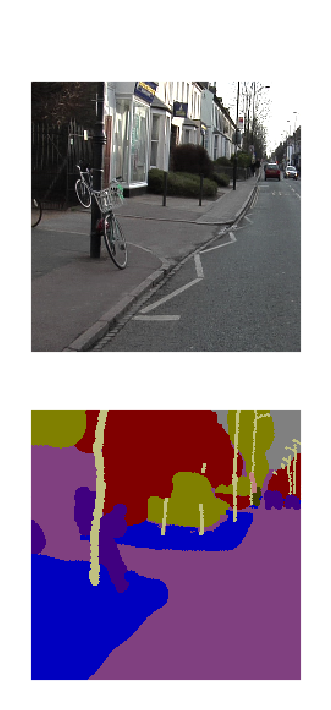

In [7]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [9]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
)

In [14]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['training'],
    epochs=10,#50,
    steps_per_epoch=10,#int(491 / 12),
    validation_data=generators['validation'],
    validation_steps=10,#int(210 / 12),
    callbacks=[EarlyStopping(monitor='loss'), PlotLossesKeras()],
    verbose=0
)

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:535: RuntimeWarning: Early stopping conditioned on metric `sadf` which is not available. Available metrics are: iou_Road,iou_Column_Pole,acc,val_mean_iou,loss,iou_Fence,val_iou_Road,iou_SignSymbol,iou_Sidewalk,val_iou_Building,iou_Car,val_iou_Sky,iou_Pedestrian,val_iou_SignSymbol,mean_iou,val_iou_Fence,iou_Sky,val_iou_Bicyclist,val_iou_Tree,val_iou_Pedestrian,val_acc,iou_Bicyclist,iou_Tree,iou_Building,val_iou_Sidewalk,val_iou_Column_Pole,val_iou_Car,val_loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [ ]:
history_to_results(history)

In [ ]:
metrics = model.evaluate_generator(generators['validation'], steps=210)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

In [ ]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

In [ ]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

In [ ]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = model.predict(X)
p = camvid11.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1])

In [ ]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2])

## Save Model

In [ ]:
# serialize weights to HDF5
model.save_weights('models/SegNet-CamVid11-coarse.h5')

# Clear Session

remove the current model from memory.

In [ ]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [ ]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=coarse_crop, batch_size=12)
generators = camvid11.generators()

In [ ]:
# get the next X, y training tuple
X, y = next(generators['training'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0])

In [ ]:
# build the model for the image shape and number of labels
tune_model = segnet.build_segnet((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
)
# load the weights from the coarsely trained model
tune_model.load_weights('./models/SegNet-CamVid11-coarse.h5')

In [ ]:
# fit the model with the data. use a small max queue size to 
# prevent an OOM error due to large image size
history = tune_model.fit_generator(generators['training'],
    epochs=10,#50,
    steps_per_epoch=10,#491,
    validation_data=generators['validation'],
    validation_steps=10,#210,
    callbacks=[EarlyStopping(monitor='loss'), PlotLossesKeras()],
    verbose=0,
    max_queue_size=1
)

In [ ]:
history_to_results(history)

In [ ]:
metrics = tune_model.evaluate_generator(generators['validation'], steps=210)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['val'])

In [ ]:
X, y = next(generators['training'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

In [ ]:
X, y = next(generators['validation'])
y = camvid11.unmap(y)
p = tune_model.predict(X)
p = camvid11.unmap(p)

In [ ]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0])

## Save Model

In [ ]:
# serialize weights to HDF5
tune_model.save_weights('models/SegNet-CamVid11-fine.h5')